In [ ]:
#############################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#############################################################################################################
# Investigate relationships between several quantitative evaluation metrics and 5 personality traits. 
#############################################################################################################

In [1]:
###############################################################################################################
# Statistics of personality labels associated with subjects / SIDs
# There are 5 labels for each SID, at continuous scale: 1-10
# Labels obtained from self-assessment
###############################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import glob
import time

#############################################
# Load data

# 5 personality dimensions/traits (Big 5 model); ordered as columns in the labels dataset
personality_dims = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..
# Labels are ordered as unique_srt_SIDs
personality_data = np.loadtxt('./../Dataset/Labels/personality_self_assessments.csv', delimiter=',', skiprows=1, dtype=float, usecols=(0, 1,2,3,4,5))

######################
# Create matrix of continuous labels, removing subject PID19 (not used at all)
cont_labels = [] # continuous labels
for i, SID in enumerate(personality_data[:,0]):
    SID = 'PID{:02.0f}'.format(SID)
    #print SID
    if SID in unique_srt_SIDs:
        cont_labels.append( personality_data[i, 1:] )
cont_labels = np.array( cont_labels )
print cont_labels

############################################################
# Binary labels (low/high) are assigned depending whether the personality trait score is above average
means = np.mean(cont_labels, axis=0)
binary_labels = np.zeros(cont_labels.shape)
for i in range(cont_labels.shape[0]):
    for j in range(cont_labels.shape[1]):
        if cont_labels[i,j] > means[j]:
            binary_labels[i,j] = 1.
print binary_labels
print len(cont_labels), len(binary_labels)


[[  3.5   7.    7.    7.    3. ]
 [  5.5   6.5   7.5   7.5   7. ]
 [  9.    7.    9.    3.5   8. ]
 [  9.5   5.5   8.    3.    5.5]
 [  8.    7.    8.    6.    6.5]
 [  9.    5.5  10.    5.5   9.5]
 [  8.5   7.5   8.    3.5   6.5]
 [  2.5   2.    7.    5.5   8.5]
 [  7.5   6.    6.    2.5   9. ]
 [  5.    3.5   6.    8.5   9. ]
 [  5.    6.5   7.    3.5   3. ]
 [  7.    8.5   8.    2.5   6. ]
 [  8.5   7.    8.    6.    4.5]
 [  5.5   6.5   4.5   5.    7. ]
 [  7.5   8.5   5.    6.    5.5]
 [  7.    6.    8.5   5.    6. ]
 [  9.    7.5   6.    5.    5.5]
 [  8.    4.5   6.    5.5   7.5]
 [  6.5  10.    5.5   3.    5.5]]
[[ 0.  1.  0.  1.  0.]
 [ 0.  1.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 1.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.]
 [ 1.  1.  1.  1.  0.]
 [ 0.  1.  0.  1.  1.]
 [ 1.  1.  0.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 1

Distribution of subjects into personalities
[12, 12, 9, 12, 10]
[7, 7, 10, 7, 9]


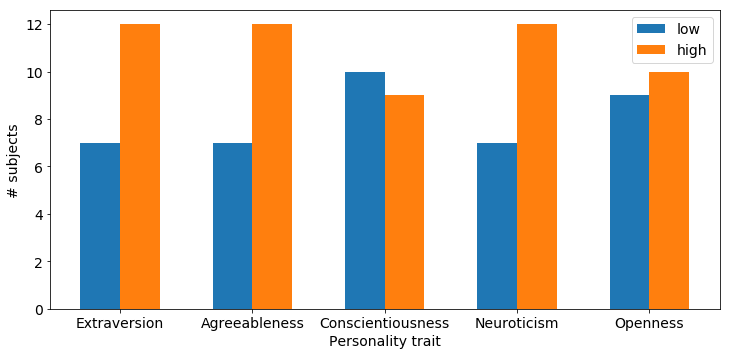

In [2]:
#############################################################
# Continuous stats, not used
#     clrs = ['red', 'green', 'yellow', 'blue', 'orange']
#     x = np.arange(len(cont_labels))
#     w = 0.15 # bar width
#     plt.figure(figsize=(20,10))
#     for i, p in enumerate(personality_dims):
#         plt.bar(x-w*(2.5-i), cont_labels[:,i], width=w, align='edge', label=p, color=clrs[i])
#     plt.xticks(x, x, rotation=0)
#     plt.ylabel('Personality trait', fontsize=14)
#     plt.xlabel('Subject', fontsize=14)
#     plt.legend()
#     plt.show()

#     for i, p in enumerate(personality_dims):
#         plt.figure(figsize=(20,10))
#         plt.bar(x, cont_labels[:,i], width=w, align='center', label=p, color=clrs[i])
#         plt.xticks(x, x, rotation=0)
#         plt.ylabel('Personality trait', fontsize=14)
#         plt.xlabel('Subject', fontsize=14)
#         plt.legend()
#         plt.show()

#############################################################
# Binary stats
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
print "Distribution of subjects into personalities"
ones  = [np.count_nonzero(binary_labels[:,i]) for i in range(5)]
zeros = [len(binary_labels) - np.count_nonzero(binary_labels[:,i]) for i in range(5)]
print ones
print zeros

x = np.arange(len(personality_dims))
w = 0.3 # bar width
# plt.figure(figsize=(12,8))
plt.figure(figsize=(12,5.5))
# plt.figure()
plt.bar(x-w/2, zeros, width=w, label='low')
plt.bar(x, ones, width=w, label='high', align='edge')
plt.xticks(x, personality_dims, rotation=0)
plt.xlabel('Personality trait')#, fontsize=14)
plt.ylabel('# subjects')#, fontsize=14)
plt.legend()
# plt.ylim(3,8)
plt.show()

In [4]:
##################################################################################
# Load quantitative evaluation metrics for all 4 models
##################################################################################

import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from tabulate import tabulate
from evalutils import plot_4RMSE, calculate_norm_delta_jerk_onList, ACC_onList

model_types = [
    'MLP SI',
    'LSTM SI',
    'MLP SD',
    'LSTM SD'
]

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..

DATA = {} # stores all measures for all model types

for m in model_types:
    DATA[m] = np.zeros( ( len(unique_srt_SIDs), 5+11 ) ) # loss, RMSE, deltaLCCAxy, LCCAyy, deltaJerk

##########################################################################################
# MLP_SI
# TESTING
##########################################################################################

m = 'MLP SI'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/cvTest/'
for s, SID in enumerate(unique_srt_SIDs):
    dd = np.load(save_results_path_prefix + 'test_' + SID + '.npz')
    DATA[m][s, 0] = dd['test_loss']
    DATA[m][s, 1] = dd['results_smooth'][1][0]
    DATA[m][s, 2] = abs(dd['results_smooth'][3]['XYt'][0] - dd['results_smooth'][3]['XYp'][0])  
    DATA[m][s, 3] = dd['results_smooth'][3]['YtYp'][0]
    #DATA[m][s, 4] = np.sum( dd['results_smooth'][4]['delta'] ) # sum over all angles
    #DATA[m][s, 5:] = dd['results_smooth'][0][0]
    
    # Calculate ACC instead of CCAyy
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 5] = ACC_onList(Y_true_list, Y_pred_list)
    
    # RECALCULATED JERK !!!
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 4] = np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) )
    
##########################################################################################
# LSTM_SI
# TESTING
##########################################################################################

m = 'LSTM SI'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/LSTM_SI/cvTest/'
for s, SID in enumerate(unique_srt_SIDs):
    dd = np.load(save_results_path_prefix + 'test_' + SID + '.npz')
    DATA[m][s, 0] = dd['test_loss']
    DATA[m][s, 1] = dd['results_smooth'][1][0]
    DATA[m][s, 2] = abs(dd['results_smooth'][3]['XYt'][0] - dd['results_smooth'][3]['XYp'][0])  
    DATA[m][s, 3] = dd['results_smooth'][3]['YtYp'][0]
    #DATA[m][s, 4] = np.sum( dd['results_smooth'][4]['delta'] )
    #DATA[m][s, 5:] = dd['results_smooth'][0][0]
    
    # Calculate ACC instead of CCAyy
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 5] = ACC_onList(Y_true_list, Y_pred_list)
    
    # RECALCULATED JERK !!!
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 4] = np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) )
    
##########################################################################################
# MLP_SD
# TESTING
##########################################################################################

m = 'MLP SD'
tuning_type = '1_35_AF26'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SD/XXX'
for s, SID in enumerate(unique_srt_SIDs):
    dd = np.load(save_results_path_prefix + 'MSBMtest_' + SID + '_' + tuning_type + '.npz')
    DATA[m][s, 0] = dd['test_loss']
    DATA[m][s, 1] = dd['results_smooth'][1][0]
    DATA[m][s, 2] = abs(dd['results_smooth'][3]['XYt'][0] - dd['results_smooth'][3]['XYp'][0])  
    DATA[m][s, 3] = dd['results_smooth'][3]['YtYp'][0]
    #DATA[m][s, 5:] = dd['results_smooth'][0][0]
    
    # RECALCULATED JERK !!!
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 4] = np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) )
    
    # Calculate ACC instead of CCAyy
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 5] = ACC_onList(Y_true_list, Y_pred_list)

##########################################################################################
# LSTM_SD
# TESTING
##########################################################################################

m = 'LSTM SD'
tuning_type = '1_26_12'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/LSTM_SD/'
for s, SID in enumerate(unique_srt_SIDs):
    dd = np.load(save_results_path_prefix + 'MSBMtest_' + tuning_type + '_' + SID + '.npz')
    DATA[m][s, 0] = dd['test_loss']
    DATA[m][s, 1] = dd['results_smooth'][1][0]
    DATA[m][s, 2] = abs(dd['results_smooth'][3]['XYt'][0] - dd['results_smooth'][3]['XYp'][0])  
    DATA[m][s, 3] = dd['results_smooth'][3]['YtYp'][0]
    #DATA[m][s, 5:] = dd['results_smooth'][0][0]
    
    # RECALCULATED JERK !!!
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 4] = np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) )
    
    # Calculate ACC 
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    DATA[m][s, 5] = ACC_onList(Y_true_list, Y_pred_list)


MODEL:  MLP SI
Extraversion x Loss  -------  MLP SI
err
Agreeableness x Loss  -------  MLP SI
err
Conscientiousness x Loss  -------  MLP SI
	-0.592047127716 0.563044415927
	 samples A and B are NOT significantly different
False
Neuroticism x Loss  -------  MLP SI
err
Openness x Loss  -------  MLP SI
	0.987604864411 0.340907232072
	 samples A and B are NOT significantly different
False
	0.122727272727 0.85333968495
	 samples A and B are NOT significantly different


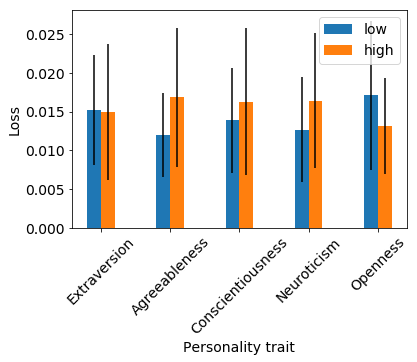

Extraversion x RMSE  -------  MLP SI
err
Agreeableness x RMSE  -------  MLP SI
err
Conscientiousness x RMSE  -------  MLP SI
	0.590644356532 0.563091448236
	 samples A and B are NOT significantly different
False
Neuroticism x RMSE  -------  MLP SI
err
Openness x RMSE  -------  MLP SI
	1.14767188821 0.267889383955
	 samples A and B are NOT significantly different
False
	0.0954545454545 0.978654128794
	 samples A and B are NOT significantly different


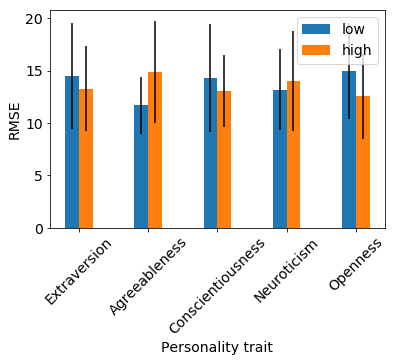

Extraversion x deltaLCCAxy  -------  MLP SI
err
Agreeableness x deltaLCCAxy  -------  MLP SI
err
Conscientiousness x deltaLCCAxy  -------  MLP SI
	0.00603923943004 0.995252058391
	 samples A and B are NOT significantly different
False
Neuroticism x deltaLCCAxy  -------  MLP SI
err
Openness x deltaLCCAxy  -------  MLP SI
	0.7 0.00905030394694
	 samples A and B are significantly different
True
	0.0954545454545 0.978654128794
	 samples A and B are NOT significantly different


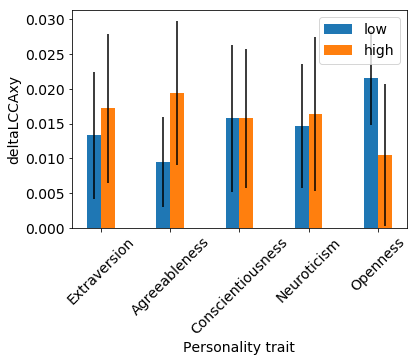

Extraversion x LCCAyy  -------  MLP SI
err
Agreeableness x LCCAyy  -------  MLP SI
err
Conscientiousness x LCCAyy  -------  MLP SI
	-1.08897351259 0.296002744934
	 samples A and B are NOT significantly different
False
Neuroticism x LCCAyy  -------  MLP SI
err
Openness x LCCAyy  -------  MLP SI
	-0.718117649014 0.484922990578
	 samples A and B are NOT significantly different
False
	-1.22785133377 0.223167587353
	 samples A and B are NOT significantly different


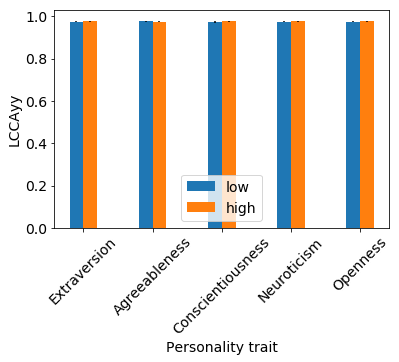

Extraversion x deltaJerk  -------  MLP SI
err
Agreeableness x deltaJerk  -------  MLP SI
err
Conscientiousness x deltaJerk  -------  MLP SI
	1.74316988338 0.115107418734
	 samples A and B are NOT significantly different
False
Neuroticism x deltaJerk  -------  MLP SI
err
Openness x deltaJerk  -------  MLP SI
	0.477777777778 0.161678565318
	 samples A and B are NOT significantly different
False
	0.188636363636 0.34661368574
	 samples A and B are NOT significantly different


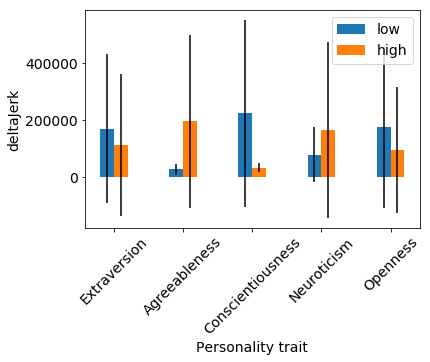

Extraversion x ACC  -------  MLP SI
err
Agreeableness x ACC  -------  MLP SI
err
Conscientiousness x ACC  -------  MLP SI
	0.119762128183 0.906095176541
	 samples A and B are NOT significantly different
False
Neuroticism x ACC  -------  MLP SI
err
Openness x ACC  -------  MLP SI
	0.542217073204 0.594707582439
	 samples A and B are NOT significantly different
False
	0.147727272727 0.657501881248
	 samples A and B are NOT significantly different


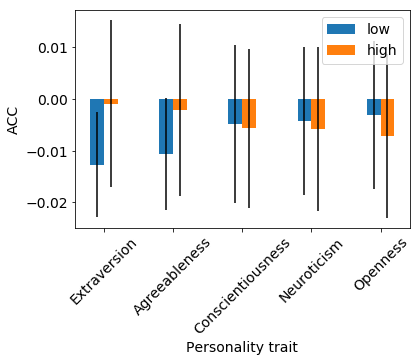

-------------------------------------------------------------------------------------------------
MODEL:  LSTM SI
Extraversion x Loss  -------  LSTM SI
err
Agreeableness x Loss  -------  LSTM SI
err
Conscientiousness x Loss  -------  LSTM SI
	-0.530382581822 0.6039907857
	 samples A and B are NOT significantly different
False
Neuroticism x Loss  -------  LSTM SI
err
Openness x Loss  -------  LSTM SI
	0.989466696236 0.340098921171
	 samples A and B are NOT significantly different
False
	0.122727272727 0.85333968495
	 samples A and B are NOT significantly different


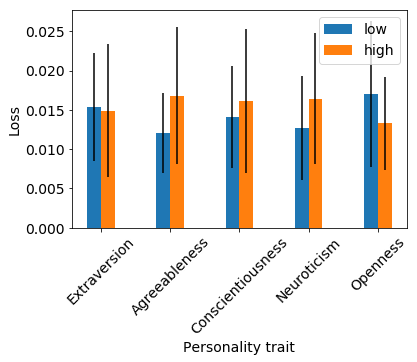

Extraversion x RMSE  -------  LSTM SI
err
Agreeableness x RMSE  -------  LSTM SI
err
Conscientiousness x RMSE  -------  LSTM SI
	0.672178453063 0.511251215812
	 samples A and B are NOT significantly different
False
Neuroticism x RMSE  -------  LSTM SI
err
Openness x RMSE  -------  LSTM SI
	0.344444444444 0.530536623621
	 samples A and B are NOT significantly different
False
	0.0954545454545 0.978654128794
	 samples A and B are NOT significantly different


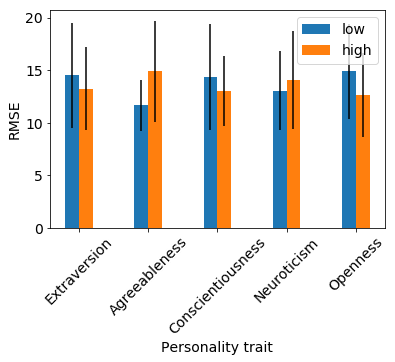

Extraversion x deltaLCCAxy  -------  LSTM SI
err
Agreeableness x deltaLCCAxy  -------  LSTM SI
err
Conscientiousness x deltaLCCAxy  -------  LSTM SI
	1.69910342263 0.109413544029
	 samples A and B are NOT significantly different
False
Neuroticism x deltaLCCAxy  -------  LSTM SI
err
Openness x deltaLCCAxy  -------  LSTM SI
	1.0178698982 0.325361865957
	 samples A and B are NOT significantly different
False
	0.197727272727 0.292327350085
	 samples A and B are NOT significantly different


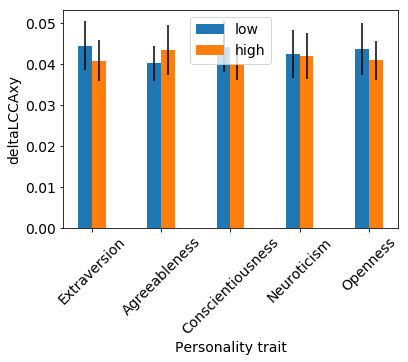

Extraversion x LCCAyy  -------  LSTM SI
err
Agreeableness x LCCAyy  -------  LSTM SI
err
Conscientiousness x LCCAyy  -------  LSTM SI
	0.5 0.127295312482
	 samples A and B are NOT significantly different
False
Neuroticism x LCCAyy  -------  LSTM SI
err
Openness x LCCAyy  -------  LSTM SI
	0.366666666667 0.449425884347
	 samples A and B are NOT significantly different
False
	0.261363636364 0.0698498962588
	 samples A and B are NOT significantly different


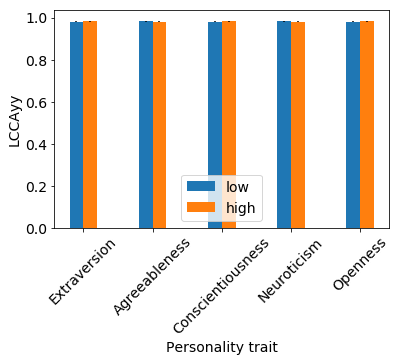

Extraversion x deltaJerk  -------  LSTM SI
err
Agreeableness x deltaJerk  -------  LSTM SI
err
Conscientiousness x deltaJerk  -------  LSTM SI
	1.74300460701 0.115139021587
	 samples A and B are NOT significantly different
False
Neuroticism x deltaJerk  -------  LSTM SI
err
Openness x deltaJerk  -------  LSTM SI
	0.477777777778 0.161678565318
	 samples A and B are NOT significantly different
False
	0.188636363636 0.34661368574
	 samples A and B are NOT significantly different


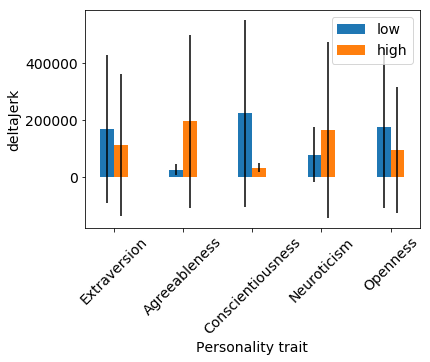

Extraversion x ACC  -------  LSTM SI
err
Agreeableness x ACC  -------  LSTM SI
err
Conscientiousness x ACC  -------  LSTM SI
	0.195961595248 0.847025135902
	 samples A and B are NOT significantly different
False
Neuroticism x ACC  -------  LSTM SI
err
Openness x ACC  -------  LSTM SI
	1.22895714808 0.237996938507
	 samples A and B are NOT significantly different
False
	0.236270396516 0.813813538071
	 samples A and B are NOT significantly different


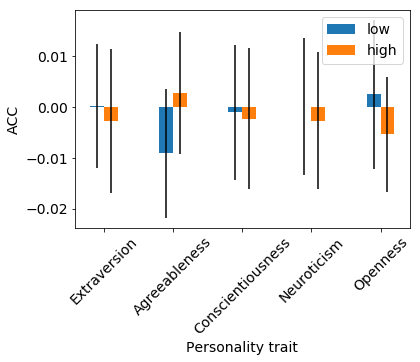

-------------------------------------------------------------------------------------------------
MODEL:  MLP SD
Extraversion x Loss  -------  MLP SD
err
Agreeableness x Loss  -------  MLP SD
err
Conscientiousness x Loss  -------  MLP SD
	0.466666666667 0.181452945052
	 samples A and B are NOT significantly different
False
Neuroticism x Loss  -------  MLP SD
err
Openness x Loss  -------  MLP SD
	0.431370517222 0.671773110095
	 samples A and B are NOT significantly different
False
	0.209090909091 0.233321811931
	 samples A and B are NOT significantly different


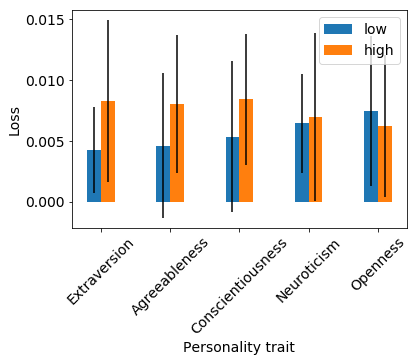

Extraversion x RMSE  -------  MLP SD
err
Agreeableness x RMSE  -------  MLP SD
err
Conscientiousness x RMSE  -------  MLP SD
	-0.49032383062 0.63047646123
	 samples A and B are NOT significantly different
False
Neuroticism x RMSE  -------  MLP SD
err
Openness x RMSE  -------  MLP SD
	0.344444444444 0.530536623621
	 samples A and B are NOT significantly different
False
	0.161363636364 0.54483126382
	 samples A and B are NOT significantly different


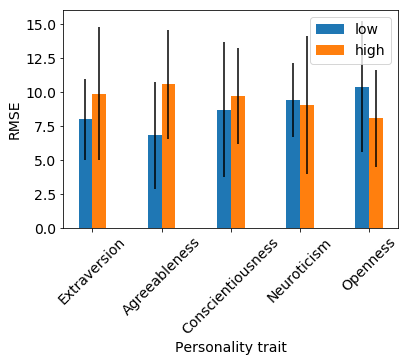

Extraversion x deltaLCCAxy  -------  MLP SD
err
Agreeableness x deltaLCCAxy  -------  MLP SD
err
Conscientiousness x deltaLCCAxy  -------  MLP SD
	-0.344884340071 0.734445988517
	 samples A and B are NOT significantly different
False
Neuroticism x deltaLCCAxy  -------  MLP SD
err
Openness x deltaLCCAxy  -------  MLP SD
	4.14029123828 0.000686497659186
	 samples A and B are significantly different
True
	0.540873521159 0.590033120238
	 samples A and B are NOT significantly different


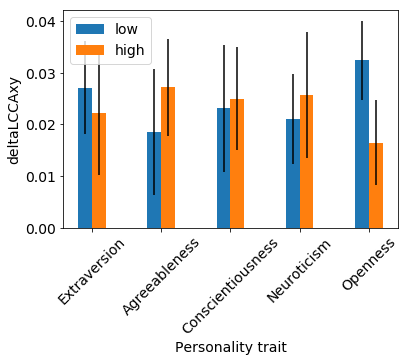

Extraversion x LCCAyy  -------  MLP SD
err
Agreeableness x LCCAyy  -------  MLP SD
err
Conscientiousness x LCCAyy  -------  MLP SD
	-2.4694633773 0.024425164386
	 samples A and B are NOT significantly different
False
Neuroticism x LCCAyy  -------  MLP SD
err
Openness x LCCAyy  -------  MLP SD
	0.815983545961 0.426971973392
	 samples A and B are NOT significantly different
False
	0.213636363636 0.212396538254
	 samples A and B are NOT significantly different


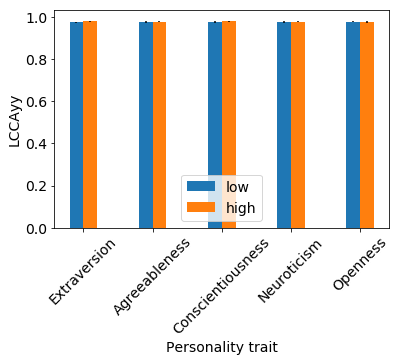

Extraversion x deltaJerk  -------  MLP SD
err
Agreeableness x deltaJerk  -------  MLP SD
err
Conscientiousness x deltaJerk  -------  MLP SD
	0.266666666667 0.828306322574
	 samples A and B are NOT significantly different
False
Neuroticism x deltaJerk  -------  MLP SD
err
Openness x deltaJerk  -------  MLP SD
	0.222222222222 0.94846794623
	 samples A and B are NOT significantly different
False
	0.131818181818 0.787078463763
	 samples A and B are NOT significantly different


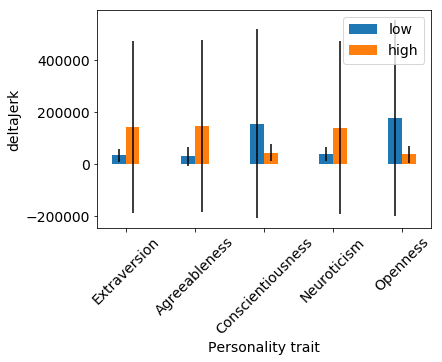

Extraversion x ACC  -------  MLP SD
err
Agreeableness x ACC  -------  MLP SD
err
Conscientiousness x ACC  -------  MLP SD
	1.67708704712 0.118817052066
	 samples A and B are NOT significantly different
False
Neuroticism x ACC  -------  MLP SD
err
Openness x ACC  -------  MLP SD
	0.277777777778 0.789008137492
	 samples A and B are NOT significantly different
False
	0.15 0.638508101571
	 samples A and B are NOT significantly different


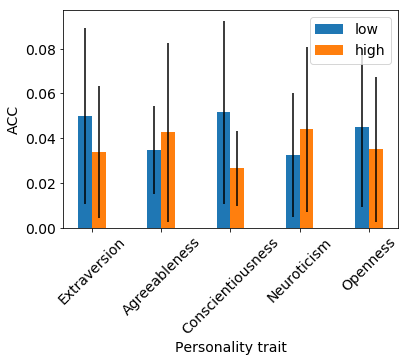

-------------------------------------------------------------------------------------------------
MODEL:  LSTM SD
Extraversion x Loss  -------  LSTM SD
err
Agreeableness x Loss  -------  LSTM SD
err
Conscientiousness x Loss  -------  LSTM SD
	0.466666666667 0.181452945052
	 samples A and B are NOT significantly different
False
Neuroticism x Loss  -------  LSTM SD
err
Openness x Loss  -------  LSTM SD
	0.377444861837 0.710659788832
	 samples A and B are NOT significantly different
False
	0.209090909091 0.233321811931
	 samples A and B are NOT significantly different


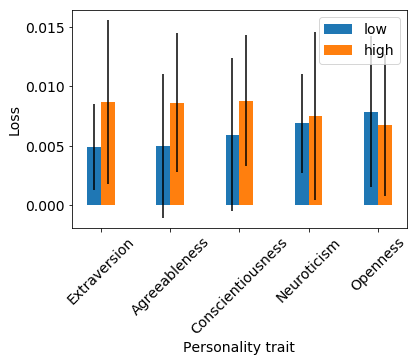

Extraversion x RMSE  -------  LSTM SD
err
Agreeableness x RMSE  -------  LSTM SD
err
Conscientiousness x RMSE  -------  LSTM SD
	-0.258163159805 0.799600242034
	 samples A and B are NOT significantly different
False
Neuroticism x RMSE  -------  LSTM SD
err
Openness x RMSE  -------  LSTM SD
	0.897190183756 0.383397276894
	 samples A and B are NOT significantly different
False
	0.165909090909 0.508639855102
	 samples A and B are NOT significantly different


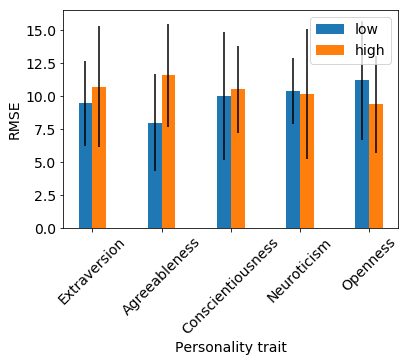

Extraversion x deltaLCCAxy  -------  LSTM SD
err
Agreeableness x deltaLCCAxy  -------  LSTM SD
err
Conscientiousness x deltaLCCAxy  -------  LSTM SD
	2.0168267717 0.0600054266424
	 samples A and B are NOT significantly different
False
Neuroticism x deltaLCCAxy  -------  LSTM SD
err
Openness x deltaLCCAxy  -------  LSTM SD
	0.683095134809 0.503811012704
	 samples A and B are NOT significantly different
False
	1.9826612006 0.0507115300658
	 samples A and B are NOT significantly different


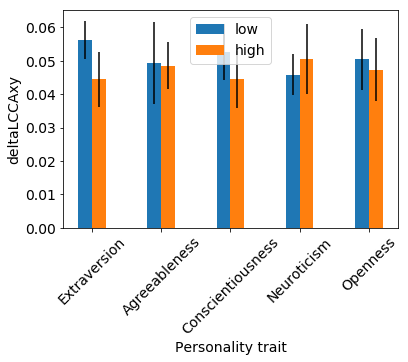

Extraversion x LCCAyy  -------  LSTM SD
err
Agreeableness x LCCAyy  -------  LSTM SD
err
Conscientiousness x LCCAyy  -------  LSTM SD
	-1.78166392829 0.093114463887
	 samples A and B are NOT significantly different
False
Neuroticism x LCCAyy  -------  LSTM SD
err
Openness x LCCAyy  -------  LSTM SD
	-0.0863239415428 0.932372029014
	 samples A and B are NOT significantly different
False
	-1.19585813706 0.235227176536
	 samples A and B are NOT significantly different


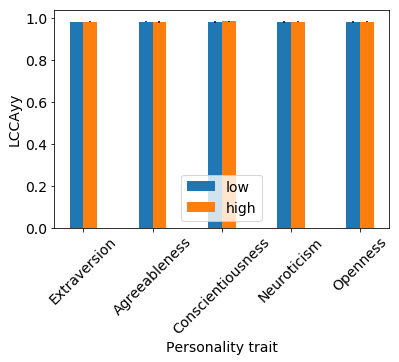

Extraversion x deltaJerk  -------  LSTM SD
err
Agreeableness x deltaJerk  -------  LSTM SD
err
Conscientiousness x deltaJerk  -------  LSTM SD
	0.266666666667 0.828306322574
	 samples A and B are NOT significantly different
False
Neuroticism x deltaJerk  -------  LSTM SD
err
Openness x deltaJerk  -------  LSTM SD
	0.222222222222 0.94846794623
	 samples A and B are NOT significantly different
False
	0.131818181818 0.787078463763
	 samples A and B are NOT significantly different


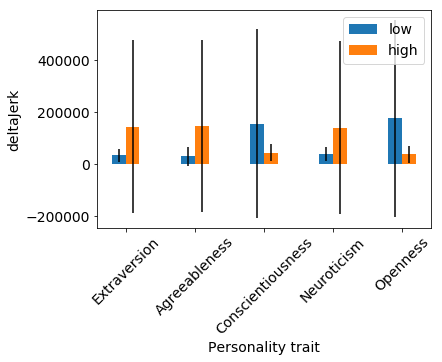

Extraversion x ACC  -------  LSTM SD
err
Agreeableness x ACC  -------  LSTM SD
err
Conscientiousness x ACC  -------  LSTM SD
	-1.10320113314 0.285995345291
	 samples A and B are NOT significantly different
False
Neuroticism x ACC  -------  LSTM SD
err
Openness x ACC  -------  LSTM SD
	0.281998892289 0.781734571107
	 samples A and B are NOT significantly different
False
	-0.253386118085 0.800653051491
	 samples A and B are NOT significantly different


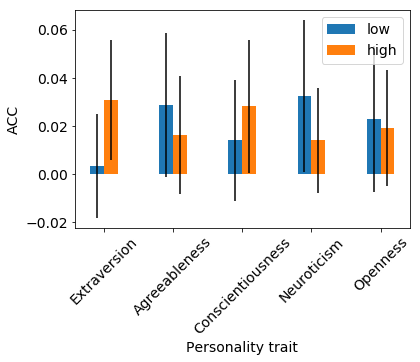

-------------------------------------------------------------------------------------------------


In [7]:
##################################################################################################################
# Examine significance of differences (in eval metrics) between low and high perosonality trait categories
##################################################################################################################

from evalutils import statistical_significance

pval = 0.01

for m in model_types:

    # m = 'MLP SI'
    print "MODEL: ", m
    measures = ['Loss', 'RMSE', 'deltaLCCAxy', 'LCCAyy', 'deltaJerk', 'ACC']
    for m_i, measure in enumerate(measures):
        plt.figure()
        w = 0.2 # bar width
        xaxis = np.arange(len(personality_dims))
        means_low = []
        means_high = []
        stds_low = []
        stds_high = []
        LOW = []
        HIGH = []
        for i, personality_dim in enumerate(personality_dims):
            print personality_dim, "x", measure, " ------- ", m
            low_bin = []
            high_bin = []
            for bin_lab, x in zip(binary_labels[:,i],DATA[m][:, m_i]):
                if bin_lab == 0.:
                    low_bin.append( float(x) )
                    LOW.append(float(x))
                elif bin_lab == 1.:
                    high_bin.append( float(x) )
                    HIGH.append(float(x))
                else:
                    raise ValueError('Incorrect binary label encountered!')
            means_low.append( np.mean(low_bin) )
            means_high.append( np.mean(high_bin) )
            stds_low.append( np.std(low_bin) )
            stds_high.append( np.std(high_bin) )
            try:
                ss = statistical_significance(low_bin, high_bin, pval, False)
                print ss
            except ValueError:
                print "err"

        statistical_significance(LOW, HIGH, pval, False)

        plt.bar(xaxis-w/2., means_low, yerr=stds_low, width=w, align='center', label='low')    # LOW
        plt.bar(xaxis, means_high, yerr=stds_high, width=w, align='edge', label='high') # HIGH
        plt.ylabel(measure) #, fontsize=14)
        plt.xlabel('Personality trait')
        plt.xticks(xaxis, personality_dims, rotation=45)
        # plt.ylim(0, 28)
        plt.legend()
        plt.show()
    
    print "-------------------------------------------------------------------------------------------------"